In [1]:
!nvidia-smi 

Mon Feb 21 08:33:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow_datasets as tfds

In [5]:
(ds_train, ds_test_), ds_info = tfds.load('mnist', split=['train', 'test'], 
                                         shuffle_files=True, with_info=True, as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
batch_size = 64

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image

In [7]:
ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)

In [8]:
def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

In [9]:
def Encoder(z_dim):
    inputs = layers.Input(shape=[28,28,1])
    x = inputs
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    z = layers.Dense(z_dim, activation='relu')(x)
    return keras.Model(inputs=inputs, outputs=z, name='encoder')

In [10]:
encoder = Encoder(10)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 111,146
Trainable params: 111,146
Non-trainab

In [11]:
def Encoder(z_dim):
    inputs = layers.Input(shape=[28,28,1])
    x = inputs
    x = layers.Conv2D(filters=8, kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    out = layers.Dense(z_dim, activation='relu')(x)
    return keras.Model(inputs=inputs, outputs=out, name='encoder')

In [12]:
encoder = Encoder(10)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 flatten_1 (Flatten)         (None, 392)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                3930

In [13]:
def Decoder(z_dim):
    inputs = layers.Input(shape=[z_dim])
    x = inputs
    x = layers.Dense(7*7*64, activation='relu')(x)
    x = layers.Reshape((7,7,64))(x)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = layers.UpSampling2D((2,2))(x)
    out = layers.Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')(x)
    return keras.Model(inputs=inputs, outputs=out, name='decoder')

In [14]:
decoder = Decoder(10)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_5 (Dense)             (None, 3136)              34496     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        18464     
                                                           

In [15]:
class Autoencoder:
    def __init__(self, z_dim):
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
        model_input = self.encoder.input
        model_output = self.decoder(self.encoder.output)
        self.model = keras.Model(model_input, model_output)

In [16]:
autoencoder = Autoencoder(z_dim=10)

In [17]:
autoencoder.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 8)         80        
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 8)         584       
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 8)           584       
                                                                 
 flatten_2 (Flatten)         (None, 392)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                3930  

In [18]:
checkpoint = keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', verbose=1,
                                             save_best_only=True, mode='auto', save_weights_only=False)

early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=5)

callbacks_list = [checkpoint, early]

autoencoder.model.compile(loss='mse', optimizer=keras.optimizers.RMSprop(learning_rate=3e-4))

In [19]:
autoencoder.model.fit(ds_train, validation_data=ds_test, epochs=100, callbacks=callbacks_list)

Epoch 1/100
938/938 [==============================] - ETA: 0s - loss: 0.0436
Epoch 1: val_loss improved from inf to 0.02876, saving model to autoencoder.h5
938/938 [==============================] - 35s 16ms/step - loss: 0.0436 - val_loss: 0.0288
Epoch 2/100
937/938 [============================>.] - ETA: 0s - loss: 0.0257
Epoch 2: val_loss improved from 0.02876 to 0.02288, saving model to autoencoder.h5
938/938 [==============================] - 15s 16ms/step - loss: 0.0257 - val_loss: 0.0229
Epoch 3/100
937/938 [============================>.] - ETA: 0s - loss: 0.0221
Epoch 3: val_loss improved from 0.02288 to 0.02203, saving model to autoencoder.h5
938/938 [==============================] - 15s 16ms/step - loss: 0.0221 - val_loss: 0.0220
Epoch 4/100
938/938 [==============================] - ETA: 0s - loss: 0.0202
Epoch 4: val_loss improved from 0.02203 to 0.01858, saving model to autoencoder.h5
938/938 [==============================] - 15s 16ms/step - loss: 0.0202 - val_loss: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'renderer' parameter of tight_layout() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'renderer', they should be pass as keyword, not positionally.


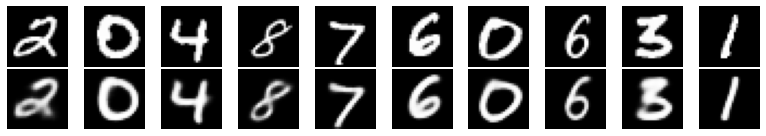

In [20]:
images, labels = next(iter(ds_test))
autoencoder.model = keras.models.load_model('autoencoder.h5')
outputs = autoencoder.model.predict(images)

grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i=0
for row in range(0, grid_row, 2):
  for col in range(grid_col):
    axarr[row, col].imshow(images[i,:,:,0],cmap='gray')
    axarr[row, col].axis('off')
    axarr[row+1, col].imshow(outputs[i,:,:,0],cmap='gray')
    axarr[row+1, col].axis('off')
    i+=1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)
plt.show()